In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = os.path.abspath(r'…')
ROOT_PATH  = os.path.dirname(os.path.dirname(os.path.dirname(parent_path)))
DataPath = os.path.join(ROOT_PATH, 'data/')

## 1. EDA -- POS_CASH_balance.csv

In [3]:
def load_data(directory_path = '', verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading the tables...")
        start = datetime.now()
    global application_train,POS_CASH_balance,credit_card_balance
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded table 1: application_train.csv")
    POS_CASH_balance = pd.read_csv(directory_path+'POS_CASH_balance.csv')
    if verbose:
        print("Loaded table 2: POS_CASH_balance.csv")
    credit_card_balance = pd.read_csv(directory_path+'credit_card_balance.csv')
    if verbose:
        print("Loaded table 3: credit_card_balance.csv")
    if verbose:
        print("Loaded 3 tables.")
        print("Done.")
        print(f'Time Taken to load 8 tables = {datetime.now() - start}')
    

In [4]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [5]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [6]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [7]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

### 1.1 Load Data

In [8]:
load_data(directory_path=DataPath)

Loading the tables...
Loaded table 1: application_train.csv
Loaded table 2: POS_CASH_balance.csv
Loaded table 3: credit_card_balance.csv
Loaded 3 tables.
Done.
Time Taken to load 8 tables = 0:00:26.861598


### 1.2 Print Basic Information

In [9]:
print(f'The shape of POS_CASH_balance.csv is: {POS_CASH_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of duplicate values in POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

The shape of POS_CASH_balance.csv is: (10001358, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [10]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(POS_CASH_balance)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
4,CNT_INSTALMENT_FUTURE,0.260835
3,CNT_INSTALMENT,0.260675


----------------------------------------------------------------------------------------------------


**POS_CASH_balance.csv** has total 8 columns with 2 columns including missing values

### 1.3 Correlation Analysis

In [11]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


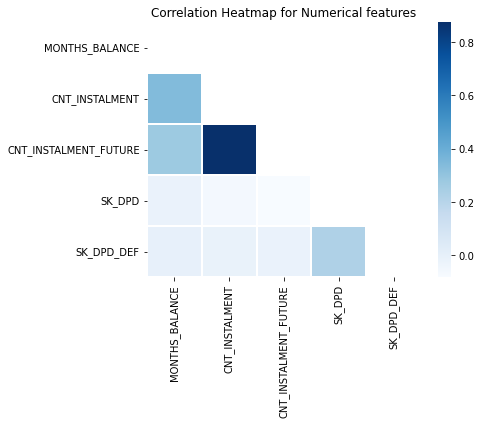

----------------------------------------------------------------------------------------------------


In [12]:
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

The correlation between **CNT_INSTALMENT** and **CNT_INSTALMENT_FUTURE** is relatively high

See more details in the following top correlation table

In [13]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,CNT_INSTALMENT_FUTURE,0.033194
1,CNT_INSTALMENT,0.030947
0,MONTHS_BALANCE,0.027391
3,SK_DPD,0.012773
4,SK_DPD_DEF,0.010539


----------------------------------------------------------------------------------------------------


The correlation of features with Target isn't noticeable.

### 1.4 Continuous Values Analysis

We first get an averaged level information of **POS_CASH_balance** corresponding to each **SK_ID_PREV**

In [14]:
pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

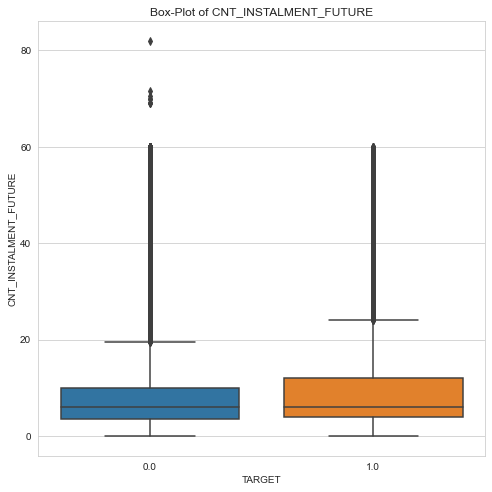

In [15]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))

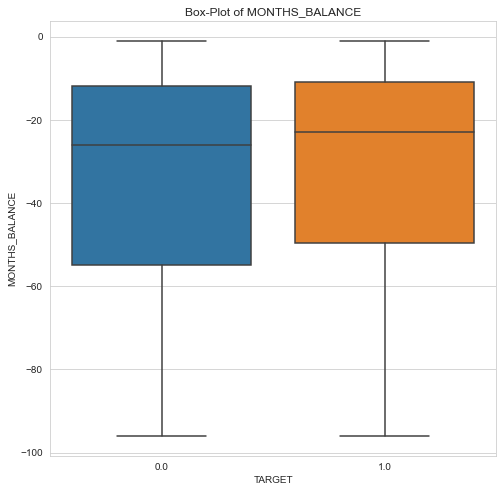

In [16]:
plot_continuous_variables(pos_cash_merged, 'MONTHS_BALANCE', plots = ['box'], figsize = (8,8))

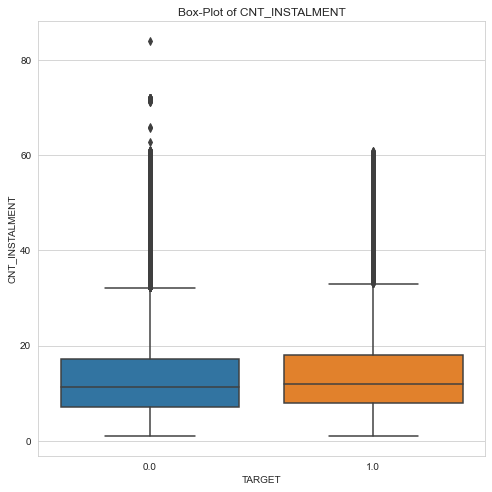

In [17]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT', plots = ['box'], figsize = (8,8))

The box-plots tell us that the Defaulters tend to have more number of Installments remaining on their previous credits as compared to Non-Defaulters.

## 2. EDA -- credit_card_balance.csv

### 2.1 Print Basic Information

In [18]:
print(f'The shape of credit_card_balance.csv is: {credit_card_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of duplicate values in credit_card_balance: {credit_card_balance.shape[0] - credit_card_balance.duplicated().shape[0]}')
print('-'*100)
display(credit_card_balance.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
10,AMT_PAYMENT_CURRENT,19.998063
5,AMT_DRAWINGS_ATM_CURRENT,19.524872
18,CNT_DRAWINGS_POS_CURRENT,19.524872
7,AMT_DRAWINGS_OTHER_CURRENT,19.524872
8,AMT_DRAWINGS_POS_CURRENT,19.524872
17,CNT_DRAWINGS_OTHER_CURRENT,19.524872
15,CNT_DRAWINGS_ATM_CURRENT,19.524872
19,CNT_INSTALMENT_MATURE_CUM,7.948208
9,AMT_INST_MIN_REGULARITY,7.948208


----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


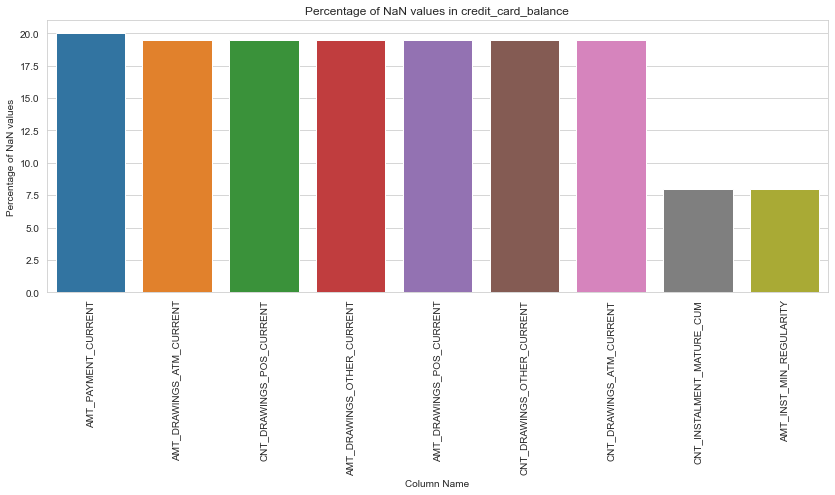

----------------------------------------------------------------------------------------------------


In [19]:
credit_card_balance_nan = nan_df_create(credit_card_balance)
print('-'*100)
print("Columns with NaN values and their percentages:")
display(credit_card_balance_nan[credit_card_balance_nan.percent != 0])
print('-'*100)
plot_nan_percent(credit_card_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del credit_card_balance_nan

**credit_card_balance.csv** has total 23 columns with 9 columns including missing values, and 7 of these features have close to 20% missing values.

### 2.2 Correlation Analysis

In [20]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
credit_card_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


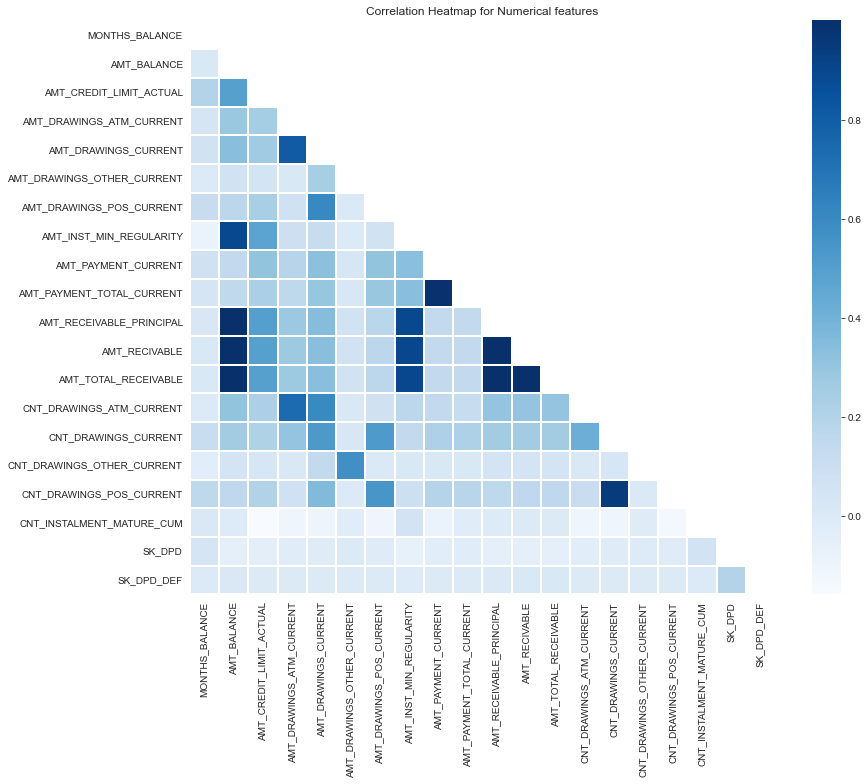

----------------------------------------------------------------------------------------------------


In [21]:
corr_mat = correlation_matrix(credit_card_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [22]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.059838
11,AMT_RECIVABLE,0.059311
12,AMT_TOTAL_RECEIVABLE,0.059287
10,AMT_RECEIVABLE_PRINCIPAL,0.058895
0,MONTHS_BALANCE,0.050360
7,AMT_INST_MIN_REGULARITY,0.042174
17,CNT_INSTALMENT_MATURE_CUM,0.038261
13,CNT_DRAWINGS_ATM_CURRENT,0.030052
2,AMT_CREDIT_LIMIT_ACTUAL,0.028752
14,CNT_DRAWINGS_CURRENT,0.027868


----------------------------------------------------------------------------------------------------


The correlation of features with Target isn't noticeable

### 2.3 Continuous Values Analysis

We first get an averaged level information of **credit_card_balance** corresponding to each **SK_ID_PREV**

In [23]:
credit_card_balance_merged = credit_card_balance_merged.groupby('SK_ID_PREV').mean()

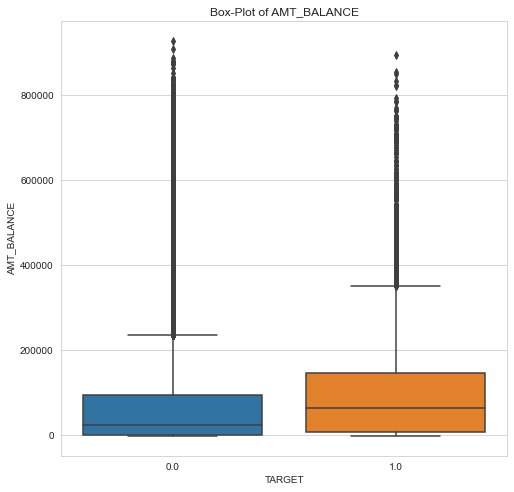

In [24]:
plot_continuous_variables(credit_card_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

Credit amount for Defaulters could also be relatively higher as compared to Non-Defaulters.

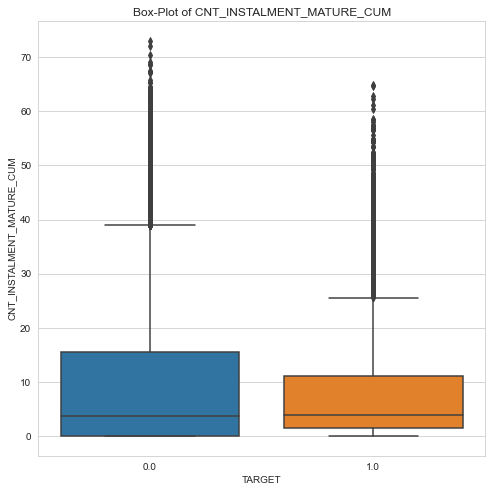

In [25]:
plot_continuous_variables(credit_card_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.

## 3. Feature Engineering -- POS_CASH_balance.csv

In [26]:
class preprocess_POS_CASH_balance:
    '''
    Preprocess the POS_CASH_balance table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the POS_CASH_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#          Pre-processing POS_CASH_balance.csv          #')
            print('#########################################################')
            print("\nLoading the DataFrame, POS_CASH_balance.csv, into memory...")

        self.pos_cash = pd.read_csv(self.file_directory+'POS_CASH_balance.csv')
        self.initial_size = self.pos_cash.shape

        if self.verbose:
            print("Loaded POS_CASH_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table and create new features.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Cleaning and Feature Engineering...")

        #making the MONTHS_BALANCE Positive
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        #computing Exponential Moving Average for some features based on MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_'+ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha = 0.6).mean())

        #creating new features based on Domain Knowledge
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] + self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] + self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations_sk_id_prev(self):
        '''
        Function to aggregated the POS_CASH_balance rows over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            Aggregated POS_CASH_balance table over SK_ID_PREV
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nAggregations over SK_ID_PREV...")
            
        #aggregating over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE' : ['max'],
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max','last'],
            'EXP_POS_TOTAL_TERM' : ['mean'] 
        }
#         aggregations_for_year = {
#             'CNT_INSTALMENT' : ['mean', 'max','min'],
#             'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
#             'SK_DPD' : ['max','sum'],
#             'SK_DPD_DEF' : ['max','sum'],
#             'EXP_CNT_INSTALMENT' : ['last'],
#             'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
#             'SK_DPD_RATIO' : ['mean','max'],
#             'TOTAL_TERM' : ['mean','max'],
#             'EXP_POS_TOTAL_TERM' : ['last'] 
#         }
        aggregations_for_categories = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV
        pos_cash_aggregated_overall = self.pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
        pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
        pos_cash_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace = True)

        #yearwise aggregations
#         self.pos_cash['YEAR_BALANCE'] = self.pos_cash['MONTHS_BALANCE'] //12
#         #aggregating over SK_ID_PREV for each last 2 years
#         pos_cash_aggregated_year = pd.DataFrame()
#         for year in range(2):
#             group = self.pos_cash[self.pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
#             group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
#             if year == 0:
#                 pos_cash_aggregated_year = group
#             else:
#                 pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for rest of the years
#         pos_cash_aggregated_rest_years = self.pos_cash[self.pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
#         pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
        #merging all the years aggregations
#         pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on = 'SK_ID_PREV', how = 'outer')
#         self.pos_cash = self.pos_cash.drop(['YEAR_BALANCE'], axis = 1)

        #aggregating over SK_ID_PREV for each of NAME_CONTRACT_STATUS categories
        contract_type_categories = ['Active', 'Completed']
        pos_cash_aggregated_contract = pd.DataFrame()
        for i, contract_type in enumerate(contract_type_categories):
            group = self.pos_cash[self.pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                pos_cash_aggregated_contract = group
            else:
                pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on = 'SK_ID_PREV', how = 'outer')

        pos_cash_aggregated_rest_contract = self.pos_cash[(self.pos_cash['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.pos_cash['NAME_CONTRACT_STATUS'] != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        pos_cash_aggregated_rest_contract.columns = ['_'.join(ele).upper() + '_REST' for ele in pos_cash_aggregated_rest_contract.columns]
        #merging the categorical aggregations
        pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(pos_cash_aggregated_rest_contract, on = 'SK_ID_PREV', how = 'outer')    

        #merging all the aggregations
#         pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on = 'SK_ID_PREV', how = 'outer')
#         pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on = 'SK_ID_PREV', how = 'outer')
######更改
        pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_contract, on = 'SK_ID_PREV', how = 'outer')

        #onehot encoding the categorical feature NAME_CONTRACT_TYPE
        name_contract_dummies = pd.get_dummies(self.pos_cash['NAME_CONTRACT_STATUS'], prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #concatenating one-hot encoded categories with main table
        self.pos_cash = pd.concat([self.pos_cash, name_contract_dummies], axis=1)
        #aggregating these over SK_ID_PREV as well
        aggregated_cc_contract = self.pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()    

        #merging with the final aggregations
        pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')
                
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
        
        return pos_cash_aggregated

    def aggregations_sk_id_curr(self, pos_cash_aggregated):
        '''
        Function to aggregated the aggregateed POS_CASH_balance table over SK_ID_CURR
        
        Inputs:
            self
            pos_cash_aggregated: DataFrame
                aggregated pos_cash table over SK_ID_PREV
                
        Returns:
            pos_cash_balance table aggregated over SK_ID_CURR
        '''
        
        #aggregating over SK_ID_CURR
        columns_to_aggregate = pos_cash_aggregated.columns[1:]
        #defining the aggregations to perform
        aggregations_final = {}
        for col in columns_to_aggregate:
            if 'MEAN' in col:
                aggregates = ['mean','sum','max']
            else:
                aggregates = ['mean']
            aggregations_final[col] = aggregates
        pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
        pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]
        
        return pos_cash_aggregated_final
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of POS_CASH_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated POS_CASH_balance table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #performing the data pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #performing aggregations over SK_ID_PREV
        pos_cash_aggregated = self.aggregations_sk_id_prev()
        
        if self.verbose:
            print("\nAggregation over SK_ID_CURR...")
        #doing aggregations over each SK_ID_CURR
        pos_cash_aggregated_final = self.aggregations_sk_id_curr(pos_cash_aggregated)
        
        if self.verbose:
            print('\nDone preprocessing POS_CASH_balance.')
            print(f"\nInitial Size of POS_CASH_balance: {self.initial_size}")
            print(f'Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: {pos_cash_aggregated_final.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl')
            with open(self.file_directory + 'POS_CASH_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(pos_cash_aggregated_final, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return pos_cash_aggregated_final

In [27]:
pos_aggregated = preprocess_POS_CASH_balance(file_directory=DataPath,dump_to_pickle=True).main()

#########################################################
#          Pre-processing POS_CASH_balance.csv          #
#########################################################

Loading the DataFrame, POS_CASH_balance.csv, into memory...
Loaded POS_CASH_balance.csv
Time Taken to load = 0:00:08.858064

Starting Data Cleaning and Feature Engineering...
Done.
Time Taken = 0:05:56.506503

Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:21.724262

Aggregation over SK_ID_CURR...

Done preprocessing POS_CASH_balance.

Initial Size of POS_CASH_balance: (10001358, 8)
Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: (337252, 113)

Total Time Taken = 0:06:33.643414

Pickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


In [28]:
class preprocess_credit_card_balance:
    '''
    Preprocess the credit_card_balance table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations method
        5. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the credit_card_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#        Pre-processing credit_card_balance.csv         #')
            print('#########################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.cc_balance = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        self.initial_size = self.cc_balance.shape

        if self.verbose:
            print("Loaded credit_card_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table, by removing erroneous points, and then creating new domain based features.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Preprocessing and Feature Engineering...")
            
        #there is one abruptly large value for AMT_PAYMENT_CURRENT
        self.cc_balance['AMT_PAYMENT_CURRENT'][self.cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan
        #calculating the total missing values for each previous credit card
        self.cc_balance['MISSING_VALS_TOTAL_CC'] = self.cc_balance.isna().sum(axis = 1)
        #making the MONTHS_BALANCE Positive
        self.cc_balance['MONTHS_BALANCE'] = np.abs(self.cc_balance['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.cc_balance = self.cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,0])

        #Creating new features
        self.cc_balance['AMT_DRAWING_SUM'] = self.cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['AMT_DRAWINGS_CURRENT'] + self.cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['AMT_DRAWINGS_POS_CURRENT']
        self.cc_balance['BALANCE_LIMIT_RATIO'] = self.cc_balance['AMT_BALANCE'] / (self.cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        self.cc_balance['CNT_DRAWING_SUM'] = self.cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['CNT_DRAWINGS_CURRENT'] + self.cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['CNT_DRAWINGS_POS_CURRENT'] + self.cc_balance['CNT_INSTALMENT_MATURE_CUM']
        self.cc_balance['MIN_PAYMENT_RATIO'] = self.cc_balance['AMT_PAYMENT_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['AMT_INTEREST_RECEIVABLE'] = self.cc_balance['AMT_TOTAL_RECEIVABLE'] - self.cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        self.cc_balance['SK_DPD_RATIO'] = self.cc_balance['SK_DPD'] / (self.cc_balance['SK_DPD_DEF'] + 0.00001)
        
        #calculating the rolling Exponential Weighted Moving Average over months for certain features
        rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO' ]
        exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
        self.cc_balance[exp_weighted_columns] = self.cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations(self):
        '''
        Function to perform aggregations of rows of credit_card_balance table, first over SK_ID_PREV,
        and then over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated credit_card_balance table.
        '''

        if self.verbose:
            print("\nAggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR")

        #performing aggregations over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'MISSING_VALS_TOTAL_CC' : ['sum']
        }
        aggregations_for_categories = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
#         aggregations_for_year = {
#             'SK_DPD' : ['sum','max'],
#             'SK_DPD_DEF' : ['sum','max'],
#             'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
#             'CNT_DRAWING_SUM' : ['sum','max'],
#             'MIN_PAYMENT_RATIO': ['min','mean'],
#             'PAYMENT_MIN_DIFF' : ['min','mean'],
#             'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
#             'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
#             'SK_DPD_RATIO' : ['max','mean'],
#             'EXP_AMT_DRAWING_SUM' : ['last'],
#             'EXP_BALANCE_LIMIT_RATIO' : ['last'],
#             'EXP_CNT_DRAWING_SUM' : ['last'],
#             'EXP_MIN_PAYMENT_RATIO' : ['last'],
#             'EXP_PAYMENT_MIN_DIFF' : ['last'],
#             'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
#             'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
#             'EXP_SK_DPD_RATIO' : ['last']
#         }
        #performing overall aggregations over SK_ID_PREV for all features
        cc_balance_aggregated_overall = self.cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
        cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
        cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

        #aggregating over SK_ID_PREV for different categories
        contract_status_categories = ['Active','Completed']
        cc_balance_aggregated_categories = pd.DataFrame()
        for i, contract_type in enumerate(contract_status_categories):
            group = self.cc_balance[self.cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                cc_balance_aggregated_categories = group
            else:
                cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of the categories
        cc_balance_aggregated_categories_rest = self.cc_balance[(self.cc_balance['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
        #merging all the categorical aggregations
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for different years
#         self.cc_balance['YEAR_BALANCE'] = self.cc_balance['MONTHS_BALANCE'] //12
#         cc_balance_aggregated_year = pd.DataFrame()
#         for year in range(2):
#             group = self.cc_balance[self.cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
#             group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
#             if year == 0:
#                 cc_balance_aggregated_year = group
#             else:
#                 cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
#         #aggregating over SK_ID_PREV for rest of years
#         cc_balance_aggregated_year_rest = self.cc_balance[self.cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
#         cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
#         #merging all the yearwise aggregations
#         cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
#         self.cc_balance = self.cc_balance.drop('YEAR_BALANCE', axis = 1)

        #merging all the aggregations
        cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
#         cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')

        #one-hot encoding the categorical column NAME_CONTRACT_STATUS
        name_contract_dummies = pd.get_dummies(self.cc_balance.NAME_CONTRACT_STATUS, prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()     
        #merging the one-hot encoded feature with original table
        self.cc_balance = pd.concat([self.cc_balance, name_contract_dummies], axis=1)
        #aggregating over SK_ID_PREV the one-hot encoded columns
        aggregated_cc_contract = self.cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        #merging with the aggregated table
        cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        #now we will aggregate on SK_ID_CURR
        #As seen from EDA, since most of the SK_ID_CURR had only 1 credit card, so for aggregations, we will simply take the means
        cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()
                    
        return cc_aggregated
                    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of credit_card_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated credit_card_balance table.
        '''
        
        #loading the dataframe 
        self.load_dataframe()
        #preprocessing and performing Feature Engineering
        self.data_preprocessing_and_feature_engineering()
        #aggregating over SK_ID_PREV and SK_ID_CURR
        cc_aggregated = self.aggregations()

        if self.verbose:
            print('\nDone preprocessing credit_card_balance.')
            print(f"\nInitial Size of credit_card_balance: {self.initial_size}")
            print(f'Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: {cc_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl')
            with open(self.file_directory + 'credit_card_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(cc_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)
                    
        return cc_aggregated


In [29]:
cc_aggregated = preprocess_credit_card_balance(file_directory=DataPath,dump_to_pickle = True).main()

#########################################################
#        Pre-processing credit_card_balance.csv         #
#########################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded credit_card_balance.csv
Time Taken to load = 0:00:10.163022

Starting Preprocessing and Feature Engineering...
Done.
Time Taken = 0:01:31.512009

Aggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR

Done preprocessing credit_card_balance.

Initial Size of credit_card_balance: (3840312, 23)
Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: (103558, 168)

Total Time Taken = 0:01:58.355496

Pickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------
